# Micrograd (part 1)

Github [link](https://github.com/karpathy/micrograd)

Env: __minigrad_env__ in conda

A tiny Autograd engine (tiny!)

Implement backpropagation (reverse-mode autodiff)

This is a pytorch-like API, and good for learning the basic code of pytorch.

Is that micrograd useful? Yes and No.
* yes because this helps you know how thing works foundmentally.
* No because this is worse than using Pytorch.

There are only 250 lines of code that become the spine of the whole deep learning training.

## some simple examples to show the idea of how to compute derivative based on simple math

In [2]:
# import packages (always)
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# give a quadratic function as an example
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

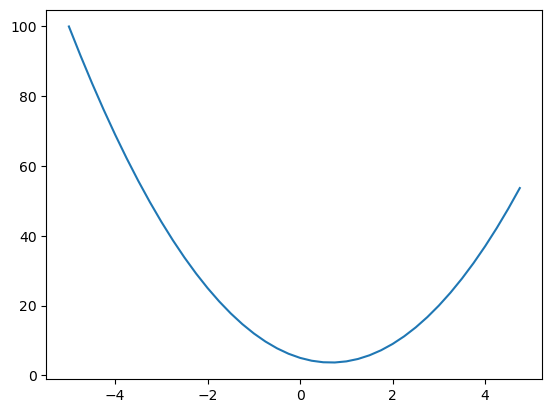

In [3]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Now think about what is the derivative of this functin at different x?

* for human, we write out the derivative of the function (symbolic way)
* for computers, they use the defination of the derivative [wiki link](https://en.wikipedia.org/wiki/Derivative)

$L = \lim\limits_{h \rightarrow 0} \frac{f(a+h)-f(a)}{h}$

In [4]:
h = 0.0000001
x = -3.0
L = (f(x+h)-f(x))/h
L


-21.999999688659955

In [5]:
# more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [6]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Move to the neural network

The first thing to do is to create a class 'Value' to save all the varibales into computation graph for autograd

In [85]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = '') -> None:
        self.data = data
        self._prev = set(_children)   # the prev nodes in computation graph
        self._op = _op   # store the operation type
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None 
        
    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward        
        return out 
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad
        out._backward = _backward  
        return out 
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(o):    
            if o not in visited:
                visited.add(o)
                for child in o._prev:
                    build_topo(child)
                topo.append(o)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [24]:
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+ c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d* f; L.label = 'L'
L, L._prev, L._op

(Value(data=-8.0), {Value(data=-2.0), Value(data=4.0)}, '*')

To visualize the computation graph, we can use graphviz package

In [25]:

from graphviz import Digraph

def trace(root):
    # build a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir': 'LR'})  # left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s |data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid+n._op, label = n._op)
            dot.edge(uid+n._op, uid)
        
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

    

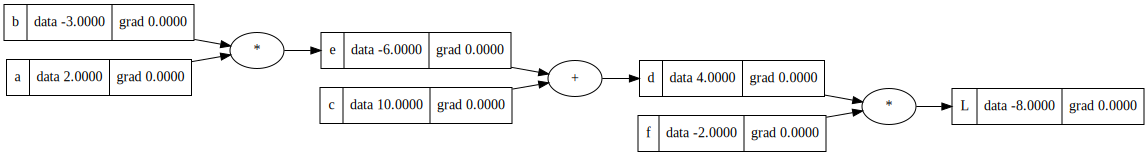

In [29]:
draw_dot(L)

## Now it is time to run backpropagation

In [30]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e+ c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d* f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e+ c; d.label = 'd'
    f = Value(-2.0+h, label = 'f')
    L = d* f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)    
lol()

3.9999999999995595


L = d * f

what is  dL/dd = ? (f)


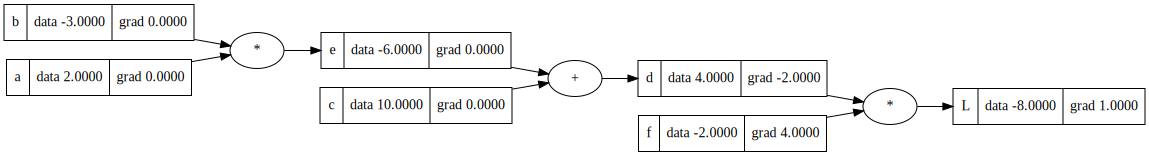

In [31]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
draw_dot(L)

How to find  dL/dc ? use chain rule

c.grad = dL/dc = dL/dd * dd/dc = d.grad * 1.0  (because of d = e + c with + operation, the local grad is one)

same for dL/de

e.grad = dL/de = dL/dd * dd/de = d.grad * 1.0

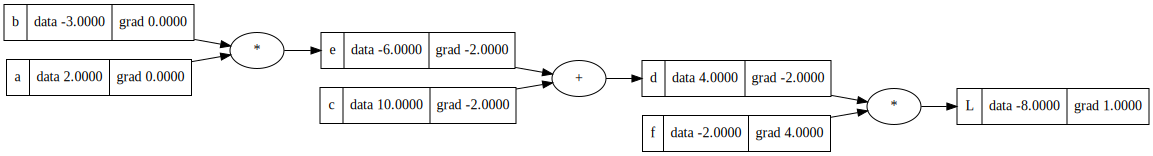

In [32]:
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
draw_dot(L)

a.grad = dL/da = dL/de * de/da = e.grad * b

b.grad = dL/db = dL/de * de/da = e.grad * a (e = a*b, so de/da = b)

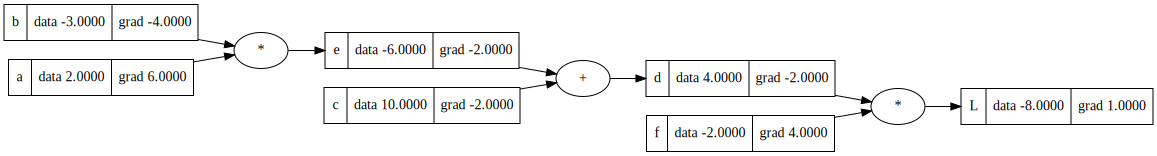

In [33]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data
draw_dot(L)

example 2, a single neuron

Now we want to use a much more complex forward path, which is a neuron


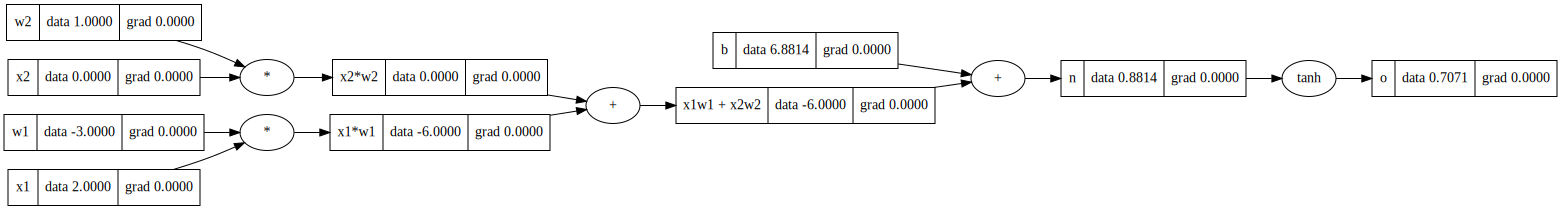

In [82]:
# input 
x1, x2 = Value(2.0, label = 'x1'), Value(0.0, label = 'x2') 
# weights
w1, w2 = Value(-3.0, label = 'w1'), Value(1.0, label = 'w2')
# bias
b = Value(6.88137, label = 'b')
# forward path
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_add_x2w2 = x1w1 + x2w2; x1w1_add_x2w2.label = 'x1w1 + x2w2'
n = x1w1_add_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

Now we can one last time fill in the _grad_ manually

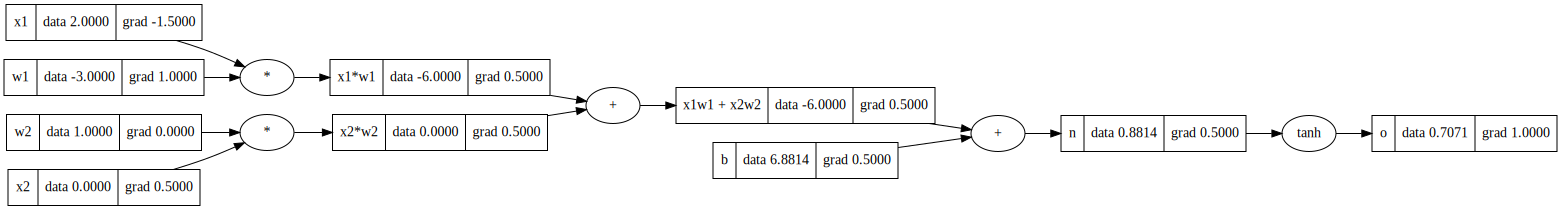

In [41]:
# do/do = 1.0
o.grad = 1.0
# do/dn = do/do * do/dn = 1.0 * (1-tanh(n)**2) = 1.0 * (1-o**2)  (o = tanh(n))
n.grad = o.grad * (1.0 - o.data**2)
# do/db = do/dn * dn/db; do/dx1w1_add_x2w2 = do/dn * dn/dx1w1_add_x2w2 (n = b + x1w1_add_x2w2)
b.grad = n.grad * 1.0
x1w1_add_x2w2.grad = n.grad * 1
# do/dx1w1 = do/dx1w1_add_x2w2 * dx1w1_add_x2w2/dx1w1; do/dx2w2 = do/dx1w_add_x2w2 * dx1w1_add_x2w2/dx2w2
x1w1.grad = x1w1_add_x2w2.grad * 1.0
x2w2.grad = x1w1_add_x2w2.grad * 1.0
# do/dx1 = do/dx1w1 * dx1w1/dx1; do/dw1 = do/dx1w1 * dx1w1/dw1
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
# do/dx2 = do/dx2w2 * dx2w2/dx2; do/dw2 = do/dx2w2 * dx2w2/dw2
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

draw_dot(o)



Afte add _backward in Value class

We have something new (autograd)

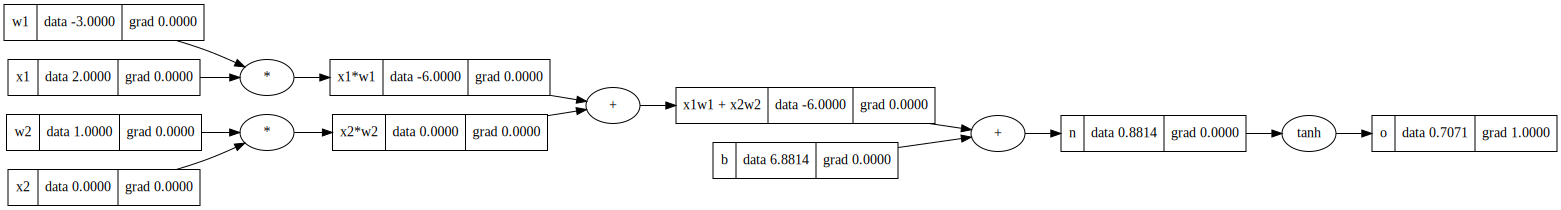

In [66]:
# input 
x1, x2 = Value(2.0, label = 'x1'), Value(0.0, label = 'x2') 
# weights
w1, w2 = Value(-3.0, label = 'w1'), Value(1.0, label = 'w2')
# bias
b = Value(6.88137, label = 'b')
# forward path
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_add_x2w2 = x1w1 + x2w2; x1w1_add_x2w2.label = 'x1w1 + x2w2'
n = x1w1_add_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

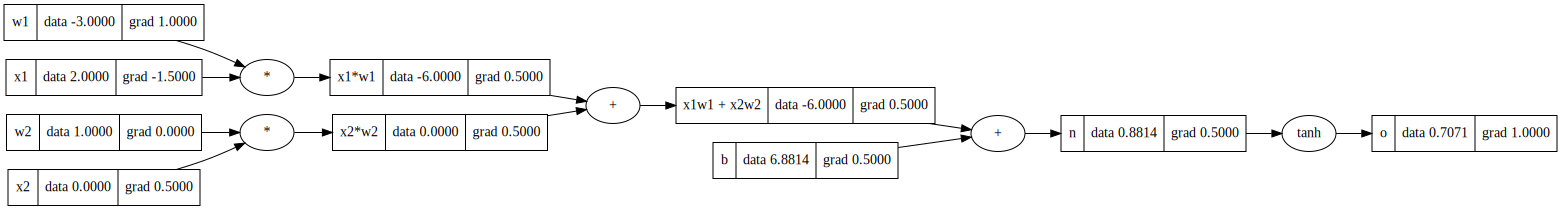

In [80]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1_add_x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

##  Now we can use topological sort to automatic backpropagation each value

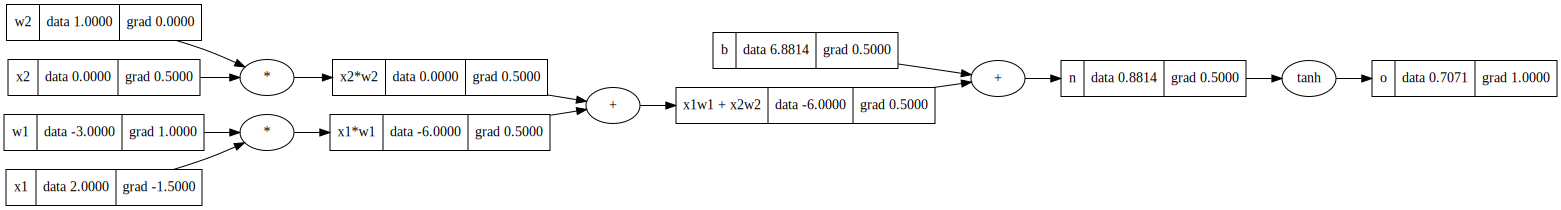

In [83]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(o):    
    if o not in visited:
        visited.add(o)
        for child in o._prev:
            build_topo(child)
        topo.append(o)
        
build_topo(o)

for node in reversed(topo):
    node._backward()
    
draw_dot(o)

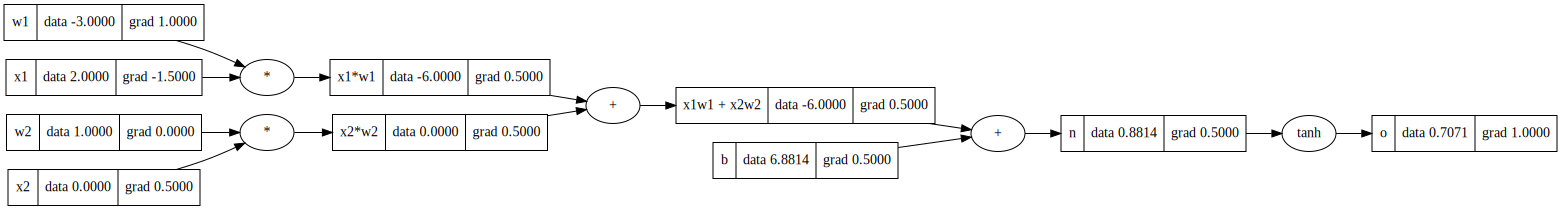

In [81]:
draw_dot(o)

create a backward function inside Value class, then we can test if it works

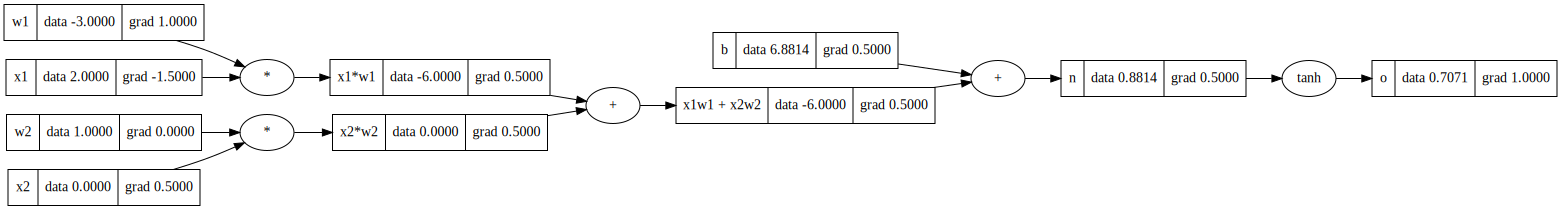

In [86]:
# input 
x1, x2 = Value(2.0, label = 'x1'), Value(0.0, label = 'x2') 
# weights
w1, w2 = Value(-3.0, label = 'w1'), Value(1.0, label = 'w2')
# bias
b = Value(6.88137, label = 'b')
# forward path
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_add_x2w2 = x1w1 + x2w2; x1w1_add_x2w2.label = 'x1w1 + x2w2'
n = x1w1_add_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# back propagation !
o.backward()
draw_dot(o)

but there is a bug, the _backward(self) in Value class should be += instead of =